In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from sklearn import datasets, model_selection, preprocessing
import tensorflow as tf
%matplotlib inline

# Neuronale Netze
![](neural_network_small.png)
Bild aus: https://de.wikipedia.org/wiki/Datei:Neural_network.svg

Ein künstliches neuronales Netz setzt sich aus vielen einzelnen künstlichen Neuronen zusammen. Diese orientieren sich lose an biologischen Neuronen. Ein einzelnes Neuron ist durch eine Aktivierungsfunktion $f:\mathbb{R}\rightarrow\mathbb{R}$, ein Gewichtvektor $w\in\mathbb{R}^{d_{in}}$ der Eingangsdimension $d_{in}\in\mathbb{N}$ und ein bias $b\in\mathbb{R}$ parametrisiert.

Die Ausgabe des künstlichen Neurons berechnet sich dann für eine Eingabe $x\in\mathbb{R}^{d_{in}}$ als:
$f\left( x \cdot w^T + b\right) = f\left( \sum_{i=1}^{d_{in}} x_i w_i + b \right)$.
![](single_neuron.png)
Bild aus: https://de.wikipedia.org/wiki/Datei:NeuronModel_deutsch.svg
            
Bekannte Aktivierungsfunktionen sind z.B.
* die Heavyside Aktivierungsfunktion $x \mapsto \begin{cases} 1 \quad \text{fuer } x \geq 0 \\ 0 \quad\text{sonst}\end{cases}$
* die relu Aktivierungsfunktion $x \mapsto \begin{cases} x \quad \text{fuer } x \geq 0 \\ 0 \quad\text{sonst}\end{cases}$
* die Sigmoid Aktivierungsfunktion $x \mapsto \frac{1}{1 + e^{-x}}$
* die Tangens hyperbolicus Aktivierungsfunktion $x \mapsto tanh(x) = 1 - \frac{2}{e^{2x} + 1}$.

Des Weiteren gibt es noch die softmax Aktivierungsfunktion. Die Ausgabe der Sigmoidfunktion ist stets im Intervall $[0,1]$ und kann damit als Wahrscheinlichkeit aufgefasst werden. Die softmax Aktivierungsfunktion wird für Multiclass Klassifikationsprobleme verwendet und wird auf einem Vektor, nicht auf einem einzelnen Wert definiert (In diesem Setting hat das neuronale Netz nicht ein Ausgabeproblem sondern so viele wie es Klassen gibt - die softmax Aktivierungsfunktion wird auf die Ausgabe angewandt und wandelt diese in einen Wahrscheinlichkeitsvektor mit den Wahrscheinlichkeiten für die einzelnen Klassen um). Die Funktion ist für $n\in\mathbb{N}$ beliebig definiert durch: $\mathbb{R}^n \ni x \mapsto  \begin{pmatrix}
\exp(x_1) / \exp\left(\sum_{i=1}^n x_i\right) \\
\vdots \\
\exp(x_n) / \exp\left(\sum_{i=1}^n x_i\right)
 \end{pmatrix}\in\mathbb{R}^n$.

## Aufgabe 1:
* Schreibe eine Funktion heavysideNeuron mit dem Interface:
```python
def heavysideNeuron(x, params):        
    # return f(x * weights^T + bias)
```
wobei `params` ein Dictionary mit Gewichten (`weights`) und Bias (`bias`) des Neurons ist.

* Initialisiere eine Variable `params` mit `weights` `[1, 2, 0]` und `bias` `-1`.
* Teste ob `heavysideNeuron` die folgenden assert Statements erfüllt.
```python
assert heavysideNeuron(np.array([1, 1, 0]), params) == 1
assert heavysideNeuron(np.array([5, 7, 0]), params) == 1
assert heavysideNeuron(np.array([0, 0.4, 1]), params) == 0
assert heavysideNeuron(np.array([-10, 4, 10]), params) == 0
print("Well done!")
```

In [6]:
def heavysideNeuron(x, params):  
    weights = params["weights"]
    bias = params["bias"]
    w=weights
    b=bias    
    out = np.dot(x, w) + b
    if out>=0: out=1
    else: out= 0
    return out         

In [7]:
weights = np.array([1,2,0])
bias = -1
params = {"weights" : weights, "bias" : bias} 

In [8]:
assert heavysideNeuron(np.array([1, 1, 0]), params) == 1
assert heavysideNeuron(np.array([5, 7, 0]), params) == 1
assert heavysideNeuron(np.array([0, 0.4, 1]), params) == 0
assert heavysideNeuron(np.array([-10, 4, 10]), params) == 0
print("Well done!")

Well done!


![](multi_layer_network.png)
Bild aus: https://de.wikipedia.org/w/index.php?title=Datei:Multi-Layer_Neural_Network-Vector.svg

Die Neuronen eines neuronalen Netzes sind hintereinander in Ebenen angeordnet. Eine Ebene eines neuronalen Netzes setzt sich aus mehreren Neuronen zusammen. Das Berechnen der Ausgaben der einzelnen Neuronen lässt sich gut mittels einer Matrixmultiplikation parallelisieren, da gilt:

Sei eine Ebene mit $n\in\mathbb{N}$ Neuronen, Aktivierungsfunktion $f$ und Eingangsdimension $d_{in}$ gegeben. Jedes Neuron (also für $i=1,\ldots,n$) habe Gewichtvektoren $w^i\in\mathbb{R}^{d_{in}}$ und bias $b^i\in\mathbb{R}$. 

Es sei $W = 
\begin{pmatrix}
w^1_1 & \ldots & w^1_{d_{in}} \\
\vdots & \ldots &\vdots \\
w^n_1 & \ldots & w^n_{d_{in}} 
 \end{pmatrix} \in\mathbb{R}^{n\times d_{in}}$
 und $B = 
\begin{pmatrix}
b^1 \\
\vdots \\
b^n
 \end{pmatrix}\in\mathbb{R}^n$
 
 
die Gesamtgewichtsmatrix bzw. der Biasvektor. Dann gilt für die Ausgabe $z^i$ des $i$-ten Neurons:
$z^i = f\left(x^T \cdot w^i + b\right) = f\left(\left( x^T W + B\right)_i\right)$.

Im Folgenden Codeausschnitt ist beispielhaft eine einzelne Ebene implementiert.

In [9]:
class SimpleLayer:
    
    def __init__(self, weights, bias, activation):
        self.weights = weights 
        self.bias = bias
        activation = activation.lower()
        
        if activation == "relu":
            self.activation = lambda x: (x >= 0).astype(float) * x
        elif activation == "sigmoid":
            self.activation = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "tanh":
            self.activation = np.tanh
        elif activation == "heavyside":
            self.activation = lambda x: (x >= 0).astype(float)
            
    def feedforward(self, inputs):
        total = np.dot(inputs,self.weights) + self.bias
        return self.activation(total)
   

## Aufgabe 2:
* Betrachte die Implementierung der obigen Klasse.
* Initialisiere eine Instanz `layer` mit den Gewichten `[[1, 0, 0], [1, 2, 3], [0, 0, 4], [1, 1, 1]]`, dem bias `[1, 0, 0]` und der Aktivierungsfunktion `relu`.
* Welche Ein / Ausgabedimensionen hat `layer`? Die Eingabedimension ist 3x4 und die Ausgabedimension ist 1x3. 
* Was ist das Ergebnis des Call-Aurufs, angewandt mit `[1, 0, 0, 5]` bzw.`[[1, 0, 0, 5], [1, 0, 3, 1]]`. Welche Bedeutung hat die zusätzliche Dimension? Die zusätzliche Dimension bedeutet die Marke, also die Klassifikationsergebnisse.

Tipp:
Initialisierung einer Instanz einer Klasse hat die folgende Form:
```python
instanz = Klassenname(parameters)
```

In [10]:
instanz = SimpleLayer(np.array([[1, 0, 0], [1, 2, 3], [0, 0, 4], [1, 1, 1]]), np.array([1,0,0]), "RELU")   


In [11]:
x= np.array([[1, 0, 0, 5], [1, 0, 3, 1], [0,0,0,0]])  
print(instanz.feedforward(x))


[[ 7.  5.  5.]
 [ 3.  1. 13.]
 [ 1.  0.  0.]]


In [12]:
x= np.array([[1, 0, 0, 5], [0, 0, 0, 0], [0,0,0,0]])  
print(instanz.feedforward(x))


[[7. 5. 5.]
 [1. 0. 0.]
 [1. 0. 0.]]


Die zusätzliche Funktion hat die Bedeutung einer Batch-Dimension. Das bedeutet über diese Dimension werden ganze Batches an Daten verarbeitet und nach Abarbeitung einer definierten Anzahl wird der Gradient zum Gradientenverfahren gebildet

# Gradientenverfahren
Gradientenverfahren bezeichnen eine Klasse von Optimierungsalgorithmen erster Ordnung, die das Ziel haben das (ein lokales) Minimum einer Funktion zu finden. Sei $n\in\mathbb{N}$ beliebig und $f:\mathbb{R}^n \rightarrow \mathbb{R}$ differenzierbar. Sei weiter eine Schrittweite $\alpha > 0 $ und ein Startwert $x_0 \in \mathbb{R}^n$ gegeben.
Ein einfaches Gradientenverfahren erzeugt dann eine Folge von $(x_n)_{n\in\mathbb{N}}$ durch:

$x_{n + 1} = x_n - \alpha \cdot \nabla f(x_n) \quad \text{ fuer } n = 1,2,3, \ldots$.

Für ein geeignetes (kleines) $\alpha > 0 $ gilt dann $f(x_{n+1}) < f(x_n)$ und die Folge konvergiert gegen ein lokales Minimum von $f$. 

Anschaulich lässt sich das dadurch begründen, dass der Gradient in die Richtung des steilsten Anstiegs einer Funktion zeigt. Dadurch, dass der Algorithmus in die Richtung des negativen Gradienten "geht" (also in die entgegengesetzte Richtung), nähert der Algorithmus sich dem Minimum.

![](sgd.png) 
Bild aus: https://en.wikipedia.org/wiki/Gradient_descent#/media/File:Gradient_descent.svg

In der folgenden Codezelle ist ein Gradientenverfahren implementiert. Hierbei wird der Gradient mittels der Funktion `f_gradient` berechnet. Die Berechnung von $\alpha \cdot \nabla f(x_n)$ wird an die Variable `optimizer` ausgelagert (siehe unten).

In [13]:
def iterate_for_(start_value, f_gradient, n_steps, optimizer):
    approximations = []
    current = start_value
    for _ in range(n_steps):
        update_by = optimizer.update(f_gradient(current))
        current = current - update_by
        
        approximations.append(current)
    return approximations

Wir testen das Gradientenverfahren anhand der einfachen quadratischen Funktion `simple_function`.

In [14]:
simple_function = lambda x : (x - 3) ** 2 + 4
simple_function_gradient = lambda x: 2 * (x - 3)

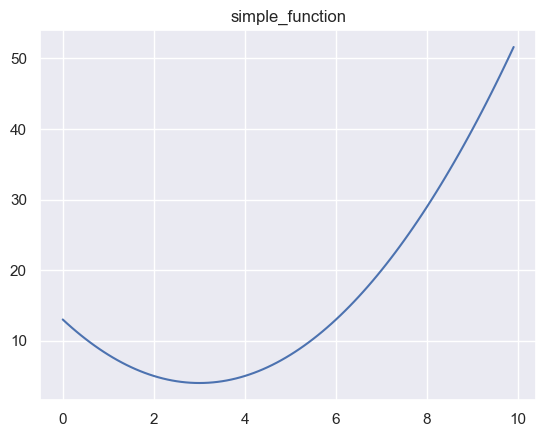

In [15]:
xs = np.arange(0, 10, 0.1)
ys = simple_function(xs)
plt.plot(xs, ys)
plt.title("simple_function")
plt.show()

![](sgdmomentum.png) 
Bild aus: https://www.willamette.edu/~gorr/classes/cs449/momrate.html

Die sogennante Lossfunktion, die bei neuronalen Netzen optimiert wird, hat im allgemeinen viele lokale Minima bzw. Sattelpunkte. Darüber hinaus wird meistens ein stochastischer Gradientenabstieg verwendet. Dabei wird der Gradient nicht bezüglich des ganzen Datensatzes berechnet, sondern lediglich bezüglich einer Teilmenge (dem sogennanten Batch). Insgesamt treten die folgenden Probleme auf:
* viele lokale Minima und Sattelpunkte
* kein exakter, sondern stochastischer Gradient
* extreme Sensibilität gegenüber der Schrittweite $\alpha$.

Deswegen wurden verschiedene Modifizierungen des einfachen Gradientenverfahrens entwickelt. Die bekannteste ist das sogenante Momentum-Verfahren. Dabei werden die vorherigen Gradienten gemittelt, sodass zufällige Effekte und Gradienten, die in unterschiedliche Richtungen zeigen (siehe Bild) gemittelt (und so deren Einflüsse reduziert) werden.

Sei $n\in\mathbb{N}$ wieder die zugrundeligende Dimension, $f:\mathbb{R}^n\rightarrow\mathbb{R}$ die zu optimierende Dimension und $x_0\in\mathbb{R}^n$ ein Startwert. 

Dann erzeugt das Momentum Verfahren zwei Folgen $(m_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$ und $(x_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$, wobei $(x_i)_{i\in\mathbb{N}}$ die Approximation der Lösung und $(m_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$ den gemittelten Gradienten darstellt. Sei weiter $\alpha > 0 $ die Schrittweite, $\gamma \in [0,1]$ ein Abklingfaktor und $m_0 = 0$. 

Dann ist das Momentumupdate für $i=1,\ldots$ gegeben durch:
$\begin{cases}
m_i = \gamma m_{i-1} + \alpha \nabla f(x_{i-1}) \\
x_i = x_{i-1} - m_i.
\end{cases}$

Das Momentumverfahren ist aber weiterhin sehr sensibel gegenüber der Schrittweite $\alpha$. Ein weiteres bekanntes Verfahren, das die Schrittweite teilweise automatisch skaliert und so weniger sensibel gegenüber der Schrittweite ist, ist das Adam-Verfahren.

Das Adam-Verfahren benutzt neben der gemittelten Gradienten auch die gemittelten zweiten Momente der Gradienten (also die quadrierten Gradienten) $\nabla f(x) \odot \nabla f(x)$. Es seien also drei Folgen $(m_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$, $(v_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$ und $(x_i)_{i\in\mathbb{N}}\subset\mathbb{R}^n$ mit $v_0=m_0=0$ sowie Abklingfaktoren $\beta_1,\beta_2\in[0,1]$, eine Schrittweite $\alpha > 0 $ und ein Regularisierungsterm $\epsilon >0$ gegeben. Dann sind die Updates des Adam-Verfahrens gegeben durch:
$\begin{cases}
m_i = \beta_1 m_{i-1} + (1-\beta_1) \nabla f(x_{i-1}) \\
v_i = \beta_2 v_{i-1} + (1-\beta_2) \left(\nabla f(x_{i-1})\odot \nabla f(x_{i-1})\right) \\
\hat{m}_i = \frac{m_i}{1- \beta_1^i} \\
\hat{v}_i = \frac{v_i}{1- \beta_2^i} \\
x_i = x_{i-1} - \alpha \frac{\hat{m}_i}{\sqrt{\hat{v}_i} + \epsilon}.
\end{cases}$

Hierbei dienen die beiden Terme $\hat{m}_i$ und $\hat{v}_i$ lediglich der Korrektur eines $0$-Biases (beide werden mit $0$ initialisiert und wären deswegen ohne die Korrektur insbesondere anfangs nahe bei $0$).

Durch die Skalierung mit den zweiten Momenten wird die Lerngeschwindigkeit in den einzelnen Dimensionen angepasst. Die Updates der Dimensionen, bei denen schon häufige Updates vorkommen, werden verringert, in Dimensionen, bei denen kaum Updates vorkamen (kleine quadrierten Gradienten), wird die Lerngeschwindigkeit erhöht.

In der Literatur findet man die Standardwerte $\beta_1 = 0.9$, $\beta_2 = 0.999$ und $\epsilon = 10^{-8}$.


Die obigen Gradientenverfahren haben wir in der Klasse `Optimizer` implementiert.

In [16]:
class Optimizer:
    
    def __init__(self, kind, parameters):
        self.kind = kind
        self.parameters = parameters
        
        #momentum
        self.m = 0
        
        # adam
        self.v = 0
        self.step = 1
        
    def update(self, current_gradient):
        if self.kind == "sgd":
            return self.parameters["alpha"] * current_gradient
        
        elif self.kind == "momentum":
            self.m = self.parameters["gamma"] * self.m + self.parameters["alpha"] * current_gradient
            return self.m
        
        elif self.kind == "adam":
            self.m = self.parameters["beta1"] * self.m + (1 - self.parameters["beta1"]) * current_gradient
            self.v = self.parameters["beta2"] * self.v + (1 - self.parameters["beta2"]) * (current_gradient ** 2)
            mhat = self.m / (1 - self.parameters["beta1"] ** self.step)
            vhat = self.v / (1 - self.parameters["beta2"] ** self.step)
            
            self.step += 1
            return self.parameters["alpha"] * mhat / (np.sqrt(vhat) + self.parameters["epsilon"])

## Aufgabe 3
* An welcher Stelle ist das Minimum von `simple_function`?
* Initialisiere eine Instanz des Momentumoptimizer mit dem Namen `momentum_optim` und den Parametern `{"alpha": 0.1, "gamma": 0.5}`.
* Teste `momentum_optim` durch den Aufruf der Funktion `iterate_for_(0, simple_function_gradient, 5, momentum_optim)`. Findet das Verfahren das Minimum?
* Plotte für $\alpha \in \{0.01, 0.1, 0.6, 0.9\}$ die ersten 30 Iterationen des einfachen Gradientenabstiegs für den Startwert 0 (siehe unten).
* Plotte für $\alpha \in \{0.01, 0.1, 0.6, 0.9\}$ und `gamma = 0.5` die ersten 30 Iterationen des Momentumoptimizers für den Startwert 0 (siehe unten).
* Plotte für $\alpha \in \{0.6, 1, 5, 10\}$ und `beta1 = 0.5, beta2 = 0.999, epsilon = 1e-8` die ersten 30 Iterationen des Adamoptimizers für den Startwert 0 (siehe unten).
* Vergleiche die Ergebnisse der drei unterschiedlichen Optimizer. Was fällt dir auf?

Tipp: Möglicherweise kannst du zum Plotten etwas der folgenden Art verwenden:
```python
plt.plot(iterate_for_(0, simple_function_gradient, 30, insert optimizer here, label="alpha: x")
# ...
plt.legend(loc="upper right")
plt.title("Plain SGD")
plt.show()
```

In [17]:
momentum_optim = Optimizer("sgd", {"alpha": 0.1, "gamma": 0.5 })

In [18]:
iterate_for_(0, simple_function_gradient, 5, momentum_optim)

[0.6000000000000001, 1.08, 1.464, 1.7711999999999999, 2.01696]

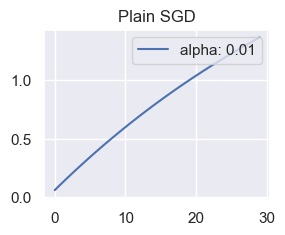

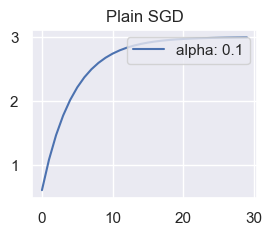

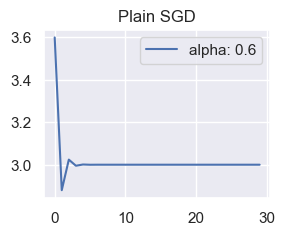

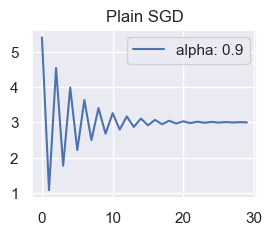

In [19]:
sgd_optim = Optimizer("sgd", {"alpha": 0.01})


plt.subplot(221)
plt.plot(iterate_for_(0, simple_function_gradient, 30, sgd_optim), label="alpha: 0.01")
plt.legend(loc="upper right")
plt.title("Plain SGD")
plt.show()
         

sgd_optim = Optimizer("sgd", {"alpha": 0.1})
plt.subplot(222)
plt.plot(iterate_for_(0, simple_function_gradient, 30, sgd_optim), label="alpha: 0.1")
plt.legend(loc="upper right")
plt.title("Plain SGD")
plt.show()

sgd_optim = Optimizer("sgd", {"alpha": 0.6})
plt.subplot(223)
plt.plot(iterate_for_(0, simple_function_gradient, 30, sgd_optim), label="alpha: 0.6")
plt.legend(loc="upper right")
plt.title("Plain SGD")
plt.show()

sgd_optim = Optimizer("sgd", {"alpha": 0.9})
plt.subplot(224)
plt.plot(iterate_for_(0, simple_function_gradient, 30, sgd_optim), label="alpha: 0.9")
plt.legend(loc="upper right")
plt.title("Plain SGD")
plt.show()


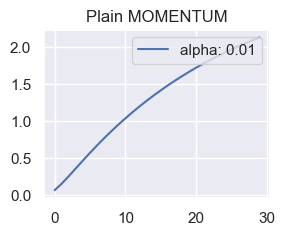

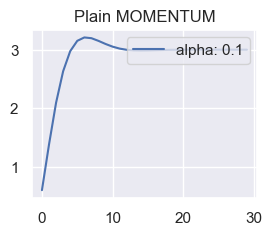

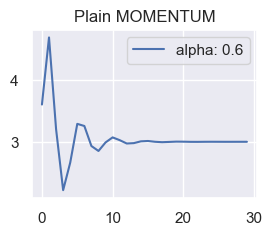

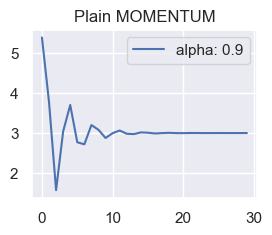

In [20]:
momentum_optim = Optimizer("momentum", {"alpha": 0.01, "gamma": 0.5 })


plt.subplot(221)
plt.plot(iterate_for_(0, simple_function_gradient, 30, momentum_optim), label="alpha: 0.01")
plt.legend(loc="upper right")
plt.title("Plain MOMENTUM")
plt.show()
         

momentum_optim = Optimizer("momentum", {"alpha": 0.1, "gamma": 0.5 })
plt.subplot(222)
plt.plot(iterate_for_(0, simple_function_gradient, 30, momentum_optim), label="alpha: 0.1")
plt.legend(loc="upper right")
plt.title("Plain MOMENTUM")
plt.show()

momentum_optim = Optimizer("momentum", {"alpha": 0.6, "gamma": 0.5 })
plt.subplot(223)
plt.plot(iterate_for_(0, simple_function_gradient, 30, momentum_optim), label="alpha: 0.6")
plt.legend(loc="upper right")
plt.title("Plain MOMENTUM")
plt.show()

momentum_optim = Optimizer("momentum", {"alpha": 0.9, "gamma": 0.5 })
plt.subplot(224)
plt.plot(iterate_for_(0, simple_function_gradient, 30, momentum_optim), label="alpha: 0.9")
plt.legend(loc="upper right")
plt.title("Plain MOMENTUM")
plt.show()

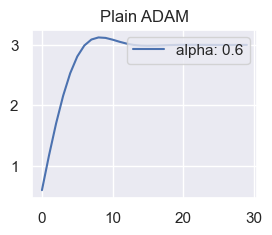

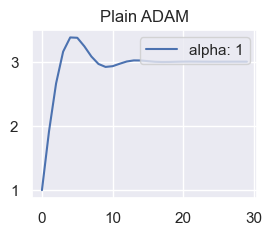

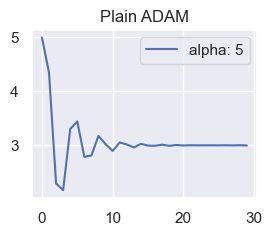

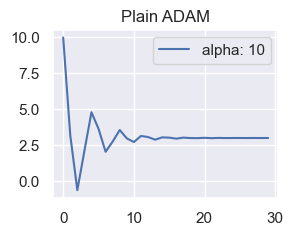

In [21]:
adam_optim = Optimizer("adam", {"alpha": 0.6, "beta1" : 0.5, "beta2" : 0.999, "epsilon" : 1e-8})


plt.subplot(221)
plt.plot(iterate_for_(0, simple_function_gradient, 30, adam_optim), label="alpha: 0.6")
plt.legend(loc="upper right")
plt.title("Plain ADAM")
plt.show()
         

adam_optim = Optimizer("adam", {"alpha": 1, "beta1" : 0.5, "beta2" : 0.999, "epsilon" : 1e-8})
plt.subplot(222)
plt.plot(iterate_for_(0, simple_function_gradient, 30, adam_optim), label="alpha: 1")
plt.legend(loc="upper right")
plt.title("Plain ADAM")
plt.show()

adam_optim = Optimizer("adam", {"alpha": 5, "beta1" : 0.5, "beta2" : 0.999, "epsilon" : 1e-8})
plt.subplot(223)
plt.plot(iterate_for_(0, simple_function_gradient, 30, adam_optim), label="alpha: 5")
plt.legend(loc="upper right")
plt.title("Plain ADAM")
plt.show()

adam_optim = Optimizer("adam", {"alpha": 10, "beta1" : 0.5, "beta2" : 0.999, "epsilon" : 1e-8})
plt.subplot(224)
plt.plot(iterate_for_(0, simple_function_gradient, 30, adam_optim), label="alpha: 10")
plt.legend(loc="upper right")
plt.title("Plain ADAM")
plt.show()

Textuelle Lösung von Aufgabe 3: 
* Das Minimum von `simple_function` ist an $x=3$. 
* Fast, das Ergebnis liegt sehr nahe bei $3$.
* Momentumoptimizer konvergiert schneller als SGD, d.h. SGD hat den langsamsten Abstieg. Wenn $\alpha=0.9$ ist, das Ergebnisse von SGD oszillieren auf beiden Seiten der Rinne weiter. Adamoptimizer ist stabiler als SGD und Momentum.

# Einführung in Keras
## Binäre Klassifikation
Zuerst generieren wir einen Testdatensatz mit sklearns `make_moons` und teilen diesen in Train/Test set auf.

<AxesSubplot:>

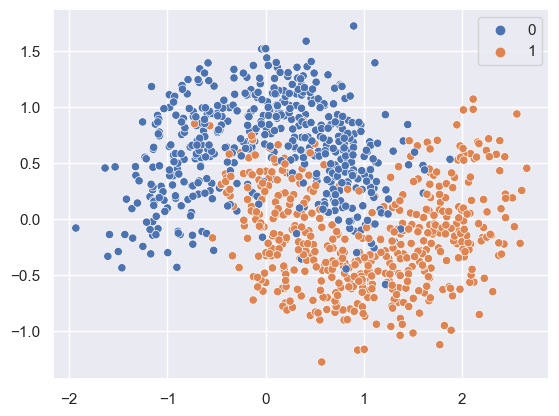

In [39]:
X, y = datasets.make_moons(n_samples=1000, random_state=2, noise=.3)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=2)

Ein neuronales Netz kann in Keras (was mittlerweile ein High-Level-Interface des Packages TensorFlow ist) über die Sequential-Klasse `tf.keras.Sequential` erstellt werden. Eine andere Option ist die direkte model-Verwendung, wie in der Vorlesung letzte Woche eingeführt. Das folgende Beispiel erzeugt klassische Feedforward-Neuronen mit Hilfe der Sequential-Klasse:

In [25]:
np.random.seed(42) #Kantengewichte eines NN werden zufällig initialisiert. Ein Seed stellt sicher, dass 
tf.random.set_seed(42) #bei der Initialisierung immer die gleichen (zufälligen) Zahlen herauskommen

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation="relu", input_shape=[2]),
tf.keras.layers.Dense(3, activation="relu")]) # Ebene mit drei Neuronen, die zwei dimensionale Daten erhält. Aktivierungsfunktion relu


model.add(tf.keras.layers.Dense(1, activation="sigmoid")) # Ebene mit einem Neuron der Aktivierungsfunktion sigmoid ("Wahrscheinlichkeit")
# Hinzufügen einer Ebene geht über den Konstruktor oder model.add

2022-12-04 01:34:06.919881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.summary() # needs input_shape in first layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 9         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


Bevor wir `model` trainieren können, müssen wir einmal `model.compile` aufrufen, um das Modell auf das Training vorzubereiten. Wir verwenden das Adam Gradientenverfahren mit einer Lerngeschwindigkeit von $10^{-2}$ und den `binary_crossentropy` loss.

In [28]:
# Compile with adam optimizer
adam = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

Anschließend können wir das Modell trainieren. Die Gradienten bezüglich des Trainingsfehlers werden dabei automatisch von TensorFlow mittels Backpropagation berechnet. Wir verwenden eine Batchgröße des stochastischen Gradientenabstiegs von $32$ und lassen den Algorithmus $20$ Epochen laufen. Eine Epoche ist ein Durchlauf über den gesamten Trainingsdatensatz. Nach jeder Epoche wird der aktuelle Loss und die Accuracy angezeigt.

In [29]:
# Fit model
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
21/21 [==============================] - 0s 760us/step - loss: 0.7586 - accuracy: 0.3119
Epoch 2/20
21/21 [==============================] - 0s 710us/step - loss: 0.6919 - accuracy: 0.5075
Epoch 3/20
21/21 [==============================] - 0s 747us/step - loss: 0.6907 - accuracy: 0.5090
Epoch 4/20
21/21 [==============================] - 0s 805us/step - loss: 0.6858 - accuracy: 0.5090
Epoch 5/20
21/21 [==============================] - 0s 716us/step - loss: 0.6548 - accuracy: 0.5090
Epoch 6/20
21/21 [==============================] - 0s 756us/step - loss: 0.5354 - accuracy: 0.8015
Epoch 7/20
21/21 [==============================] - 0s 726us/step - loss: 0.4604 - accuracy: 0.8403
Epoch 8/20
21/21 [==============================] - 0s 732us/step - loss: 0.4267 - accuracy: 0.8493
Epoch 9/20
21/21 [==============================] - 0s 740us/step - loss: 0.4077 - accuracy: 0.8478
Epoch 10/20
21/21 [==============================] - 0s 728us/step - loss: 0.3919 - accuracy: 0.8493

Nach dem Trainings können wir das Modell auf dem Testdatensatz testen und mit `model.predict` das neuronale Netz auf neue Datenpunkte anwenden.

In [30]:
model.evaluate(X_test, y_test) # evaluate on test dateset

11/11 [==============================] - 0s 690us/step - loss: 0.3002 - accuracy: 0.8788


[0.3001808524131775, 0.8787878751754761]

In [31]:
model.predict(np.array([[0, 0]])) # neuen Wert vorhersagen

1/1 [==============================] - 0s 48ms/step


array([[0.55524653]], dtype=float32)

Schlussendlich können wir noch die Entscheidungsgrenze visualisieren.

In [32]:
grid_size = 3
g_min, g_max = -grid_size, grid_size
xx, yy = np.meshgrid(np.arange(g_min, g_max, 0.1), np.arange(g_min, g_max, 0.1))
Z = model.predict(tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

113/113 [==============================] - 0s 441us/step


<AxesSubplot:>

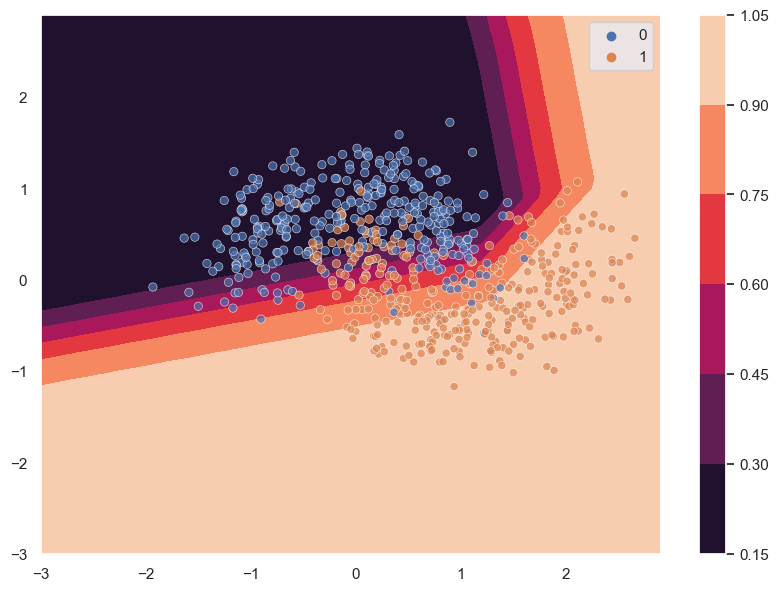

In [33]:
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z)
plt.colorbar()
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, alpha=.7)

## Aufgabe 4 (Kein Code, nur schriftliche Ausformulierung):
* Betrachte die obige Visualisierung. Kann das sehr einfache neuronale Netz den Datensatz gut approximieren? Lässt sich das anhand der accuracy erkennen?
* Wie könnte eine bessere Separierung durch das NN erreicht werden?

Lösung Aufgabe 4:
* Nein. Denn die Accuracy ist nur 87%.
* Wir können die Anzahl der Ebenen des neuronalen Netzwerks vertiefen. Außerdem können wir auch in der Lossfunktion anpassen.

## Klassifikation mit mehreren Klassen
Als nächstes versuchen wir uns an der Klassifikation im Falle von mehr als zwei Klassen.

In [53]:
X, y = datasets.make_blobs(n_samples=1000, random_state=2, centers=9, cluster_std=1.2)

In [54]:
y[(y % 3) == 0] = 0 # datensatz mit drei Klassen erstellen
y[(y % 3) == 1] = 1
y[(y % 3) == 2] = 2

<AxesSubplot:>

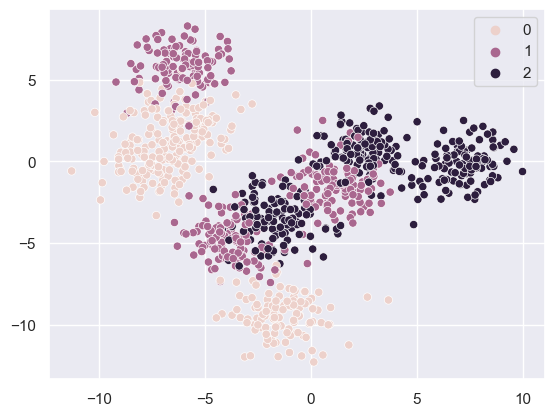

In [55]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [88]:
ohe = preprocessing.OneHotEncoder(categories="auto", sparse=False) # one hot encoding (Eine 1 im i-ten Eintrag entspricht Klasse i)
y_one_hot = ohe.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_one_hot, test_size=0.33, random_state=2)


## Aufgabe 5:
* Verwende ein neuronales Netz zur Klassifikation des obigen Datensatzes. Modifiziere das Training oder den Algorithmus so lange, bis du eine Test accuracy von $\approx 87\%$ erhältst!
* Visualisiere die Entscheidungsgrenze wie im vorherigen Beispiel. Kann das neuronale Netz die Nichtlinearität des Datensatzes besser approximieren als im vorherigen Beispiel? Ja.

Tipps: 
* Falls du Schwierigkeiten hast ein neuronales Netz zu erstellen, schaue dir das Code-Beispiel der letzten Vorlesung oder das obige Beispiel an.
* Wir Betreuer konnten mit drei verdeckten Schichten ganz gute Ergebnisse erzielen :)
* Modifziere den Visualisierungscode des obigen Beispiels für Multiklassenklassifikation mittels `np.argmax`, um so vom One Hot Encoding zurück auf eindimensionale Labels zu kommen.


In [57]:
np.random.seed(42) 
tf.random.set_seed(42)

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=[2]),
tf.keras.layers.Dense(32, activation="relu"), tf.keras.layers.Dense(128, activation="relu")])


model.add(tf.keras.layers.Dense(3, activation="sigmoid"))

In [78]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                48        
                                                                 
 dense_28 (Dense)            (None, 32)                544       
                                                                 
 dense_29 (Dense)            (None, 128)               4224      
                                                                 
 dense_30 (Dense)            (None, 3)                 387       
                                                                 
Total params: 5,203
Trainable params: 5,203
Non-trainable params: 0
_________________________________________________________________


In [79]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [80]:
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
21/21 [==============================] - 0s 933us/step - loss: 0.4473 - accuracy: 0.6119
Epoch 2/20
21/21 [==============================] - 0s 909us/step - loss: 0.2856 - accuracy: 0.7896
Epoch 3/20
21/21 [==============================] - 0s 912us/step - loss: 0.2606 - accuracy: 0.8209
Epoch 4/20
21/21 [==============================] - 0s 919us/step - loss: 0.2403 - accuracy: 0.8403
Epoch 5/20
21/21 [==============================] - 0s 900us/step - loss: 0.2229 - accuracy: 0.8642
Epoch 6/20
21/21 [==============================] - 0s 863us/step - loss: 0.2134 - accuracy: 0.8567
Epoch 7/20
21/21 [==============================] - 0s 830us/step - loss: 0.2036 - accuracy: 0.8672
Epoch 8/20
21/21 [==============================] - 0s 915us/step - loss: 0.2157 - accuracy: 0.8597
Epoch 9/20
21/21 [==============================] - 0s 865us/step - loss: 0.2192 - accuracy: 0.8522
Epoch 10/20
21/21 [==============================] - 0s 858us/step - loss: 0.1793 - accuracy: 0.8881

In [81]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 723us/step - loss: 0.1938 - accuracy: 0.8970


[0.1938297599554062, 0.8969696760177612]

In [103]:
grid_size = 15
g_min, g_max = -grid_size, grid_size
xx, yy = np.meshgrid(np.arange(g_min, g_max, 0.1), np.arange(g_min, g_max, 0.1))
Z = model.predict(tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()]))
Z_zuruck= np.argmax(Z,axis=1)
Z = Z_zuruck.reshape(xx.shape)

2813/2813 [==============================] - 1s 389us/step


<AxesSubplot:>

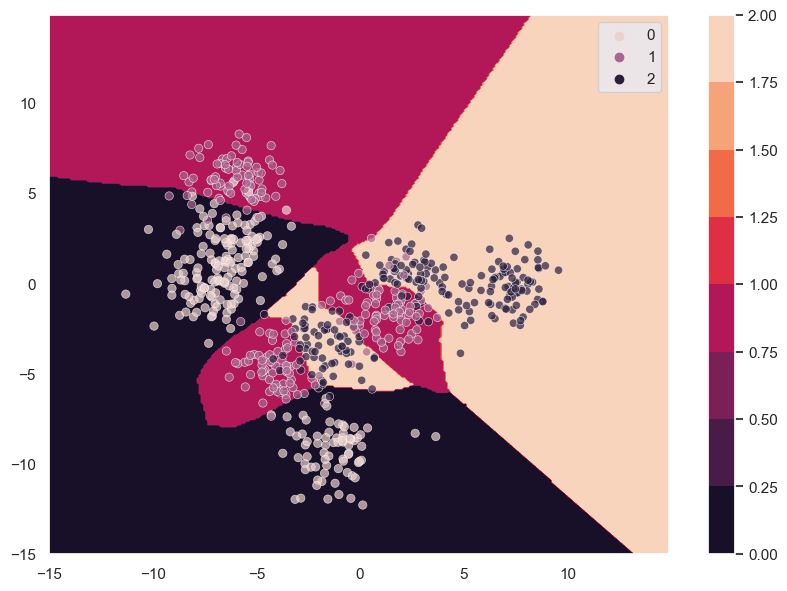

In [104]:
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z)
plt.colorbar()
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=np.argmax(y_train,axis=1), alpha=.7)

## Regression

In [108]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data()

## Aufgabe 6 (freiwillig):
* Trainiere ein neuronales Netz zur Regression auf dem bekannten obigen Datensatz. Erreiche möglichst einen MSE von $MSE < 25$ auf dem Test-Datensatz

In [119]:
X_train.shape

(404, 13)

In [120]:
y_train.shape

(404,)